# Viseklasna klasifikacija uz PCA dekompoziciju podataka

In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import losses, optimizers

from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn import datasets
from sklearn import model_selection

from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix, classification_report

import category_encoders as ce

from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [2]:
np.random.seed(10)

In [3]:
# Ucitavanje podataka iz skupa sa imenima klasa
data = pd.read_csv('kddcup.csv.data_10_percent_corrected')

data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


U svesci Provera reprezentativnosti uzorka + informacije o podacima, saznali smo da atributi 'num_outbound_cmds' i 'is_host_login' imaju sve 0, samim tim, nisu od znacaja za ucenje naseg modela pa se izbacuju.

In [4]:
data.drop(columns = ['num_outbound_cmds', 'is_host_login'], axis = 1, inplace = True)

In [5]:
# y je samo kolona sa klasom
y = data['class']

y.head()

0    normal.
1    normal.
2    normal.
3    normal.
4    normal.
Name: class, dtype: object

In [6]:
class_names = list(np.unique(y))

In [7]:
class_names

['back.',
 'buffer_overflow.',
 'ftp_write.',
 'guess_passwd.',
 'imap.',
 'ipsweep.',
 'land.',
 'loadmodule.',
 'multihop.',
 'neptune.',
 'nmap.',
 'normal.',
 'perl.',
 'phf.',
 'pod.',
 'portsweep.',
 'rootkit.',
 'satan.',
 'smurf.',
 'spy.',
 'teardrop.',
 'warezclient.',
 'warezmaster.']

In [8]:
y = y.astype('category')

# Klase kodiramo brojevima
y = y.cat.codes

np.unique(y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22], dtype=int8)

In [9]:
# Binarno kodiranje kategorisckih kolona
encoder = ce.BinaryEncoder(data, cols = ['protocol_type', 'service', 'flag'])
X = encoder.fit_transform(data)

X.head()


,duration,protocol_type_0,protocol_type_1,protocol_type_2,service_0,service_1,service_2,service_3,service_4,service_5,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,0,0,1,0,0,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,0,0,1,0,0,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,0,0,1,0,0,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,0,0,1,0,0,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,0,0,1,0,0,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [10]:
X.shape


(494021, 53)

In [11]:
# Iz podataka izbacujemo kolonu sa klasom
X = X.drop(columns = ['class'])

X.head()

,duration,protocol_type_0,protocol_type_1,protocol_type_2,service_0,service_1,service_2,service_3,service_4,service_5,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,0,0,1,0,0,0,0,0,0,...,9,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0
1,0,0,0,1,0,0,0,0,0,0,...,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0
2,0,0,0,1,0,0,0,0,0,0,...,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
3,0,0,0,1,0,0,0,0,0,0,...,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
4,0,0,0,1,0,0,0,0,0,0,...,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0


In [12]:
# Podatke delimo na trening i test skup u odnosu 2:1
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, stratify=y, random_state=7)

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [13]:
X_train.shape

(330994, 52)

In [14]:
X_test.shape

(163027, 52)

In [15]:
y_train.shape

(330994, 23)

In [16]:
y_test.shape

(163027, 23)

In [17]:
y_test[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0.], dtype=float32)

In [18]:
# Skaliranje podataka

scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
pca = PCA(n_components=15)
pca.fit(X_train, y_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [20]:
model = Sequential()
model.add(Dense(units=150, input_dim=X_train_pca.shape[1], activation='relu'))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=23, activation='softmax'))

model.compile(optimizers.Adam(learning_rate = 0.0001), loss=losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [21]:
batch_size = 128
epochs = 30

history = model.fit(X_train_pca, y_train, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/30
330994/330994 [==============================] - 48s 144us/step - loss: 0.2583 - accuracy: 0.9734
Epoch 2/30
330994/330994 [==============================] - 34s 103us/step - loss: 0.0229 - accuracy: 0.9953
Epoch 3/30
330994/330994 [==============================] - 33s 101us/step - loss: 0.0143 - accuracy: 0.9965
Epoch 4/30
330994/330994 [==============================] - 26s 79us/step - loss: 0.0116 - accuracy: 0.9971
Epoch 5/30
330994/330994 [==============================] - 22s 68us/step - loss: 0.0101 - accuracy: 0.9975
Epoch 6/30
330994/330994 [==============================] - 29s 87us/step - loss: 0.0090 - accuracy: 0.9977
Epoch 7/30
330994/330994 [==============================] - 28s 86us/step - loss: 0.0083 - accuracy: 0.9979
Epoch 8/30
330994/330994 [==============================] - 30s 90us/step - loss: 0.0076 - accuracy: 0.9980
Epoch 9/30
330994/330994 [==============================] - 23s 69us/step - loss: 0.0073 - accuracy: 0.9982
Epoch 10/30
330994/330994

In [22]:
score = model.evaluate(X_test_pca, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

163027/163027 [==============================] - 38s 231us/step
Test loss: 0.061350832794012176
Test accuracy: 0.9989633560180664


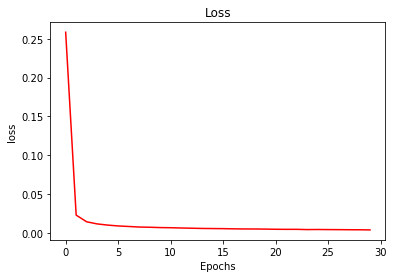

In [23]:
epochs = history.epoch

loss = history.history['loss']

plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.plot(epochs, loss, c='red')
plt.show()

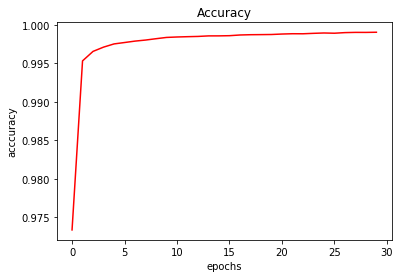

In [24]:
acc = history.history['accuracy']

plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('acccuracy')
plt.plot(epochs, acc, c='red')
plt.show()

In [25]:
y_predicted = model.predict(X_test_pca)
y_predicted_classes = np.argmax(y_predicted, axis = 1)

y_test_classes = np.argmax(y_test, axis = 1)

In [26]:
print(confusion_matrix(y_test_classes, y_predicted_classes))

[[  727     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     6     0     0     0     0     0     0     0     0     0     2
      0     0     0     0     0     0     0     0     0     2     0]
 [    0     0     1     0     0     1     0     0     0     0     0     1
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0    16     0     0     0     0     0     0     0     1
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     2     0     0     0     0     1     0     1
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0   405     0     0     0     0     1     6
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     7     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]

In [27]:
print(classification_report(y_test_classes, y_predicted_classes))

/home/vladana/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       727
           1       0.75      0.60      0.67        10
           2       1.00      0.33      0.50         3
           3       1.00      0.94      0.97        17
           4       1.00      0.50      0.67         4
           5       0.98      0.98      0.98       412
           6       1.00      1.00      1.00         7
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         2
           9       1.00      1.00      1.00     35376
          10       0.99      0.88      0.93        76
          11       1.00      1.00      1.00     32102
          12       0.50      1.00      0.67         1
          13       1.00      1.00      1.00         1
          14       1.00      0.99      0.99        87
          15       0.99      0.96      0.97       343
          16       1.00      0.33      0.50         3
          17       0.98    

In [28]:
# Ovaj kod je preuzet sa interneta u zelji da se matrica konfuzije lepse prikaze

In [29]:
from typing import List, Optional

import numpy as np
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    labels: Optional[List] = None,
    hide_zeroes: bool = False,
    hide_diagonal: bool = False,
    hide_threshold: Optional[float] = None,
):
    """Print a nicely formatted confusion matrix with labelled rows and columns.

    Predicted labels are in the top horizontal header, true labels on the vertical header.

    Args:
        y_true (np.ndarray): ground truth labels
        y_pred (np.ndarray): predicted labels
        labels (Optional[List], optional): list of all labels. If None, then all labels present in the data are
            displayed. Defaults to None.
        hide_zeroes (bool, optional): replace zero-values with an empty cell. Defaults to False.
        hide_diagonal (bool, optional): replace true positives (diagonal) with empty cells. Defaults to False.
        hide_threshold (Optional[float], optional): replace values below this threshold with empty cells. Set to None
            to display all values. Defaults to None.
    """
    if labels is None:
        labels = np.unique(np.concatenate((y_true, y_pred)))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    # find which fixed column width will be used for the matrix
    columnwidth = max(
        [len(str(x)) for x in labels] + [5]
    )  # 5 is the minimum column width, otherwise the longest class name
    empty_cell = ' ' * columnwidth

    # top-left cell of the table that indicates that top headers are predicted classes, left headers are true classes
    padding_fst_cell = (columnwidth - 3) // 2  # double-slash is int division
    fst_empty_cell = padding_fst_cell * ' ' + 't/p' + ' ' * (columnwidth - padding_fst_cell - 3)

    # Print header
    print('    ' + fst_empty_cell, end=' ')
    for label in labels:
        print(f'{label:{columnwidth}}', end=' ')  # right-aligned label padded with spaces to columnwidth

    print()  # newline
    # Print rows
    for i, label in enumerate(labels):
        print(f'    {label:{columnwidth}}', end=' ')  # right-aligned label padded with spaces to columnwidth
        for j in range(len(labels)):
            # cell value padded to columnwidth with spaces and displayed with 1 decimal
            cell = f'{cm[i, j]:{columnwidth}.1f}'
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=' ')
        print()


In [30]:
print_confusion_matrix(y_test_classes, y_predicted_classes)

     t/p      0     1     2     3     4     5     6     7     8     9    10    11    12    13    14    15    16    17    18    19    20    21    22 
        0 727.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
        1   0.0   6.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0   0.0 
        2   0.0   0.0   1.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
        3   0.0   0.0   0.0  16.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
        4   0.0   0.0   0.0   0.0   2.0   0.0   0.0   0.0   0.0   1.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
        5   0.0   0.0   0.0   0.0   0.0 405.0   0.0   0.0   0.0   0.0   1.0   6.0   0.0   0.0   0.0   0.0 